In [1]:
# Import necessary libraries for PyTorch deep learning and visualization
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any  # Import type annotations

# Fashion MNIST Classification with PyTorch

This notebook demonstrates how to build, train, and evaluate a neural network model for classifying fashion items from the Fashion MNIST dataset using PyTorch. The Fashion MNIST dataset contains 70,000 grayscale images of 10 different clothing items, with 60,000 for training and 10,000 for testing.

In [2]:
# Download and prepare the Fashion MNIST dataset
# The dataset contains 28x28 grayscale images of clothing items

# Training data: 60,000 examples
training_data: datasets.FashionMNIST = datasets.FashionMNIST(
    root="data",           # Directory where the data will be stored
    train=True,           # Specifies that this is training data
    download=True,        # Download the dataset if it doesn't exist
    transform=ToTensor(), # Convert images to PyTorch tensors and normalize (0-1)
)

# Test data: 10,000 examples
test_data: datasets.FashionMNIST = datasets.FashionMNIST(
    root="data",           # Directory where the data will be stored
    train=False,          # Specifies that this is test data
    download=True,        # Download the dataset if it doesn't exist
    transform=ToTensor(), # Convert images to PyTorch tensors and normalize (0-1)
)

## Data Preparation

In this section, we'll download the Fashion MNIST dataset and prepare it for training. The dataset consists of 28x28 grayscale images of clothing items from 10 different categories.

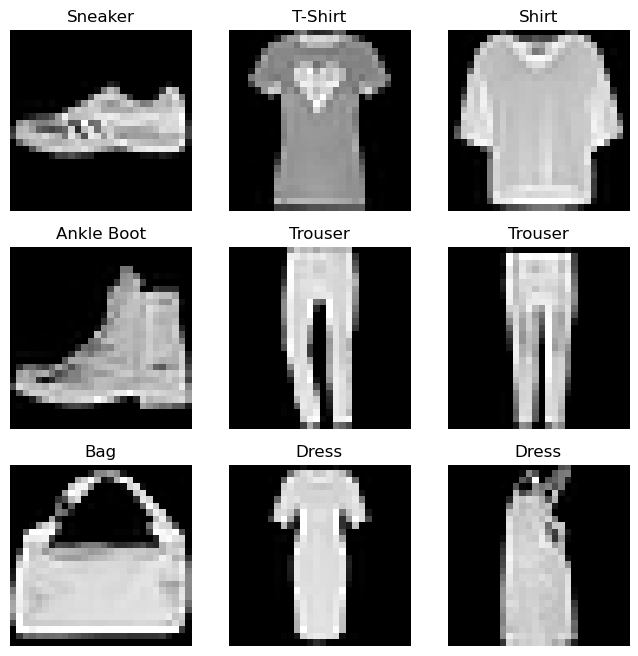

In [3]:
from typing import Dict

import matplotlib.pyplot as plt
import torch

# Create a mapping of class indices to their human-readable labels
labels_map: Dict[int, str] = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Visualize random samples from the training dataset to understand the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3  # Create a 3x3 grid of images

# Display 9 random samples with their labels
for i in range(1, cols * rows + 1):
    # Select a random image from the training dataset
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]  # Get image and its label

    # Add a subplot to our figure
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])  # Show the class name
    plt.axis("off")  # Hide axes
    plt.imshow(img.squeeze(), cmap="gray")  # Display the image in grayscale

plt.show()

## Creating DataLoaders

DataLoaders help efficiently load data in batches during training and testing. They handle shuffling, batching, and parallel loading of data.

In [4]:
from torch.utils.data import DataLoader

# Set the batch size for training and testing
# Batch size determines how many samples are processed together
batch_size: int = 64

# Create data loaders to efficiently load data during training and testing
# DataLoader provides features like batching, shuffling, and parallel data loading
train_dataloader: DataLoader = DataLoader(training_data, batch_size=batch_size)
test_dataloader: DataLoader = DataLoader(test_data, batch_size=batch_size)

# Inspect the shape of data and labels from one batch
for X, y in test_dataloader:
    # X shape is [batch_size, channels, height, width] - For MNIST: [64, 1, 28, 28]
    # y shape is [batch_size] - Labels for each image in the batch
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break  # Only inspect the first batch

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Model Definition

Now we'll define our neural network architecture for classifying the Fashion MNIST images. We'll use a simple feedforward neural network with fully connected layers.

In [5]:
# Set up the device for training (GPU if available, otherwise CPU)
device: str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define the neural network architecture with encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self):
        """
        Initialize the autoencoder with encoder and decoder layers.
        The network consists of:
        1. Encoder: Converts 2D images to latent representation
           - Flatten layer: Converts 2D images to 1D vectors
           - Two fully connected (Linear) layers with ReLU activation
        2. Decoder: Reconstructs images from latent representation
           - Two fully connected (Linear) layers with ReLU activation
           - Final layer with Sigmoid activation to output pixel values [0,1]
        """
        super().__init__()
        
        # Encoder component
        self.flatten = nn.Flatten()  # Convert 28x28 images to 784-length vectors
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),  # First hidden layer: 784 inputs, 512 outputs
            nn.ReLU(),                # ReLU activation function
            nn.Linear(512, 128),      # Second hidden layer: 512 inputs, 128 outputs
            nn.ReLU(),                # ReLU activation function
        )
        
        # Classification head (for class prediction)
        self.classifier = nn.Linear(128, 10)  # Output layer: 128 inputs, 10 outputs (one for each class)
        
        # Decoder component (for image reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),      # First decoder layer: 128 inputs, 512 outputs
            nn.ReLU(),                # ReLU activation function
            nn.Linear(512, 28 * 28),  # Output layer: 512 inputs, 784 outputs (28x28 image)
            nn.Sigmoid(),             # Sigmoid to get values between 0 and 1 (normalized pixel values)
        )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode the input images into latent representation.
        
        Args:
            x: Input tensor representing a batch of images [batch_size, 1, 28, 28]
            
        Returns:
            Latent representation [batch_size, 128]
        """
        x = self.flatten(x)           # Flatten the input: [batch_size, 784]
        x = self.encoder(x)           # Encode the input: [batch_size, 128]
        return x
        
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the autoencoder.
        
        Args:
            x: Input tensor representing a batch of images [batch_size, 1, 28, 28]
            
        Returns:
            Tuple containing:
            - class_logits: Logits for each class [batch_size, 10]
            - reconstructed: Reconstructed images [batch_size, 1, 28, 28]
        """
        # Original shape for reconstruction later
        original_shape = x.shape
        
        # Encode the input
        latent = self.encode(x)      # Get latent representation: [batch_size, 128]
        
        # Get class predictions
        class_logits = self.classifier(latent)  # Get class logits: [batch_size, 10]
        
        # Decode the latent representation
        reconstructed = self.decoder(latent)    # Reconstruct the image: [batch_size, 784]
        
        # Reshape back to original image dimensions
        reconstructed = reconstructed.view(original_shape)  # [batch_size, 1, 28, 28]
        
        return class_logits, reconstructed


# Create an instance of our model and move it to the appropriate device
model = Autoencoder().to(device)
# Print the model architecture
print(model)

Using cuda device
Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


## Setting up Loss Function and Optimizer

Before training, we need to define how to measure the model's performance (loss function) and how to update the model's parameters (optimizer).

In [6]:
# Define the loss functions and optimizer for training

# CrossEntropyLoss for classification task (predicting the fashion item class)
class_loss_fn: nn.CrossEntropyLoss = nn.CrossEntropyLoss()

# MSE Loss for reconstruction task (comparing original and reconstructed images)
recon_loss_fn: nn.MSELoss = nn.MSELoss()

# Weight factor for balancing classification and reconstruction losses
recon_weight: float = 0.5

# Stochastic Gradient Descent optimizer with learning rate 0.001
# The optimizer will update model parameters to minimize the combined loss function
optimizer: torch.optim.Adam = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training the Model

Now that we have set up our model, loss function, and optimizer, we can begin training. We'll train the model for multiple epochs, evaluating its performance on the test set after each epoch.

In [7]:
def train(dataloader: DataLoader, model: nn.Module, class_loss_fn: nn.Module, 
        recon_loss_fn: nn.Module, recon_weight: float, optimizer: torch.optim.Optimizer) -> None:
    """
    Train the model for one epoch.
    
    Args:
        dataloader: DataLoader for training data
        model: Neural network model to train
        class_loss_fn: Loss function for classification task
        recon_loss_fn: Loss function for reconstruction task
        recon_weight: Weight factor for balancing the two losses
        optimizer: Optimization algorithm for updating model parameters
    """
    # Get the total number of training examples
    size: int = len(dataloader.dataset)
    
    # Set the model to training mode (enables dropout, batch normalization, etc.)
    model.train()
    
    # Iterate through batches of data
    for batch, (X, y) in enumerate(dataloader):
        # Move data to the correct device (GPU/CPU)
        X, y = X.to(device), y.to(device)  # X: images [batch_size, 1, 28, 28], y: labels [batch_size]

        # Forward pass: compute predictions and reconstructions
        class_pred, reconstructed = model(X)  # class_pred: [batch_size, 10], reconstructed: [batch_size, 1, 28, 28]
        
        # Calculate classification loss
        class_loss = class_loss_fn(class_pred, y)
        
        # Calculate reconstruction loss
        recon_loss = recon_loss_fn(reconstructed, X)
        
        # Combine losses
        loss = class_loss + recon_weight * recon_loss

        # Backpropagation: compute gradients
        loss.backward()
        
        # Update parameters based on gradients
        optimizer.step()
        
        # Reset gradients to zero for the next iteration
        optimizer.zero_grad()

        # Print progress every 100 batches
        if batch % 100 == 0:
            loss_value: float = loss.item()
            class_loss_value: float = class_loss.item()
            recon_loss_value: float = recon_loss.item()
            current: int = (batch + 1) * len(X)
            print(f"loss: {loss_value:>7f} [class: {class_loss_value:>7f}, recon: {recon_loss_value:>7f}] [{current:>5d}/{size:>5d}]")

In [8]:
def test(
    dataloader: DataLoader, model: nn.Module, class_loss_fn: nn.Module, recon_loss_fn: nn.Module, recon_weight: float
) -> None:  # type: ignore
    """
    Evaluate the model on the test dataset.

    Args:
        dataloader: DataLoader for test data
        model: Neural network model to evaluate
        class_loss_fn: Loss function for classification task
        recon_loss_fn: Loss function for reconstruction task
        recon_weight: Weight factor for balancing the two losses
    """
    # Get total number of test examples and batches
    size: int = len(dataloader.dataset)
    num_batches: int = len(dataloader)

    # Set the model to evaluation mode (disables dropout, batch normalization uses moving averages, etc.)
    model.eval()

    test_loss: float = 0
    class_loss: float = 0
    recon_loss: float = 0
    correct: float = 0

    # Disable gradient calculation for efficiency (not needed during evaluation)
    with torch.no_grad():
        for X, y in dataloader:
            # Move data to the correct device (GPU/CPU)
            X, y = X.to(device), y.to(device)

            # Forward pass: compute predictions and reconstructions
            class_pred, reconstructed = model(X)

            # Calculate losses
            batch_class_loss = class_loss_fn(class_pred, y).item()
            batch_recon_loss = recon_loss_fn(reconstructed, X).item()
            batch_total_loss = batch_class_loss + recon_weight * batch_recon_loss

            # Accumulate losses
            test_loss += batch_total_loss
            class_loss += batch_class_loss
            recon_loss += batch_recon_loss

            # Count correct predictions (argmax picks the class with highest score)
            # class_pred.argmax(1) has shape [batch_size] - the predicted class for each example
            correct += (class_pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate average losses and accuracy across all test data
    test_loss /= num_batches
    class_loss /= num_batches
    recon_loss /= num_batches
    correct /= size

    # Print results
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, "
        f"Avg loss: {test_loss:>8f}, "
        f"Class loss: {class_loss:>8f}, "
        f"Recon loss: {recon_loss:>8f} \n"
    )

In [9]:
# Train the model for multiple epochs
# An epoch is one complete pass through the entire training dataset

epochs: int = 15  # Number of times to iterate over the entire dataset

# Training and evaluation loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Train for one epoch
    train(train_dataloader, model, class_loss_fn, recon_loss_fn, recon_weight, optimizer)
    # Evaluate on the test set
    test(test_dataloader, model, class_loss_fn, recon_loss_fn, recon_weight)
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.389887 [class: 2.303956, recon: 0.171864] [   64/60000]
loss: 0.663470 [class: 0.641449, recon: 0.044042] [ 6464/60000]
loss: 0.393207 [class: 0.375926, recon: 0.034563] [12864/60000]
loss: 0.532046 [class: 0.515148, recon: 0.033796] [19264/60000]
loss: 0.448078 [class: 0.431852, recon: 0.032452] [25664/60000]
loss: 0.443020 [class: 0.428907, recon: 0.028225] [32064/60000]
loss: 0.389585 [class: 0.376784, recon: 0.025602] [38464/60000]
loss: 0.550080 [class: 0.537026, recon: 0.026107] [44864/60000]
loss: 0.530457 [class: 0.517414, recon: 0.026087] [51264/60000]
loss: 0.517169 [class: 0.504589, recon: 0.025160] [57664/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.441924, Class loss: 0.428850, Recon loss: 0.026147 

Epoch 2
-------------------------------
loss: 0.295637 [class: 0.282484, recon: 0.026306] [   64/60000]
loss: 0.378845 [class: 0.366962, recon: 0.023766] [ 6464/60000]
loss: 0.304895 [class: 0.293887, recon: 0.022016] [12864

## Saving the Trained Model

After training, we'll save the model's parameters to a file so that we can use it later for inference without having to retrain.

In [1]:
# Save the trained model to a file
# This saves only the model parameters (weights and biases), not the entire model structure

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")
# The saved model can later be loaded and used for inference without retraining

NameError: name 'torch' is not defined

In [11]:
# Load the saved model for inference
# First, create a new instance of the model with the same architecture
model = Autoencoder().to(device)

# Then load the saved parameters (weights and biases) into this model
# weights_only=True ignores non-weight data in the file
model.load_state_dict(torch.load("model.pth", weights_only=True))

# The model is now ready for inference with the trained parameters

<All keys matched successfully>

## Making Predictions with the Model

Finally, let's use our trained model to make predictions on individual test examples.

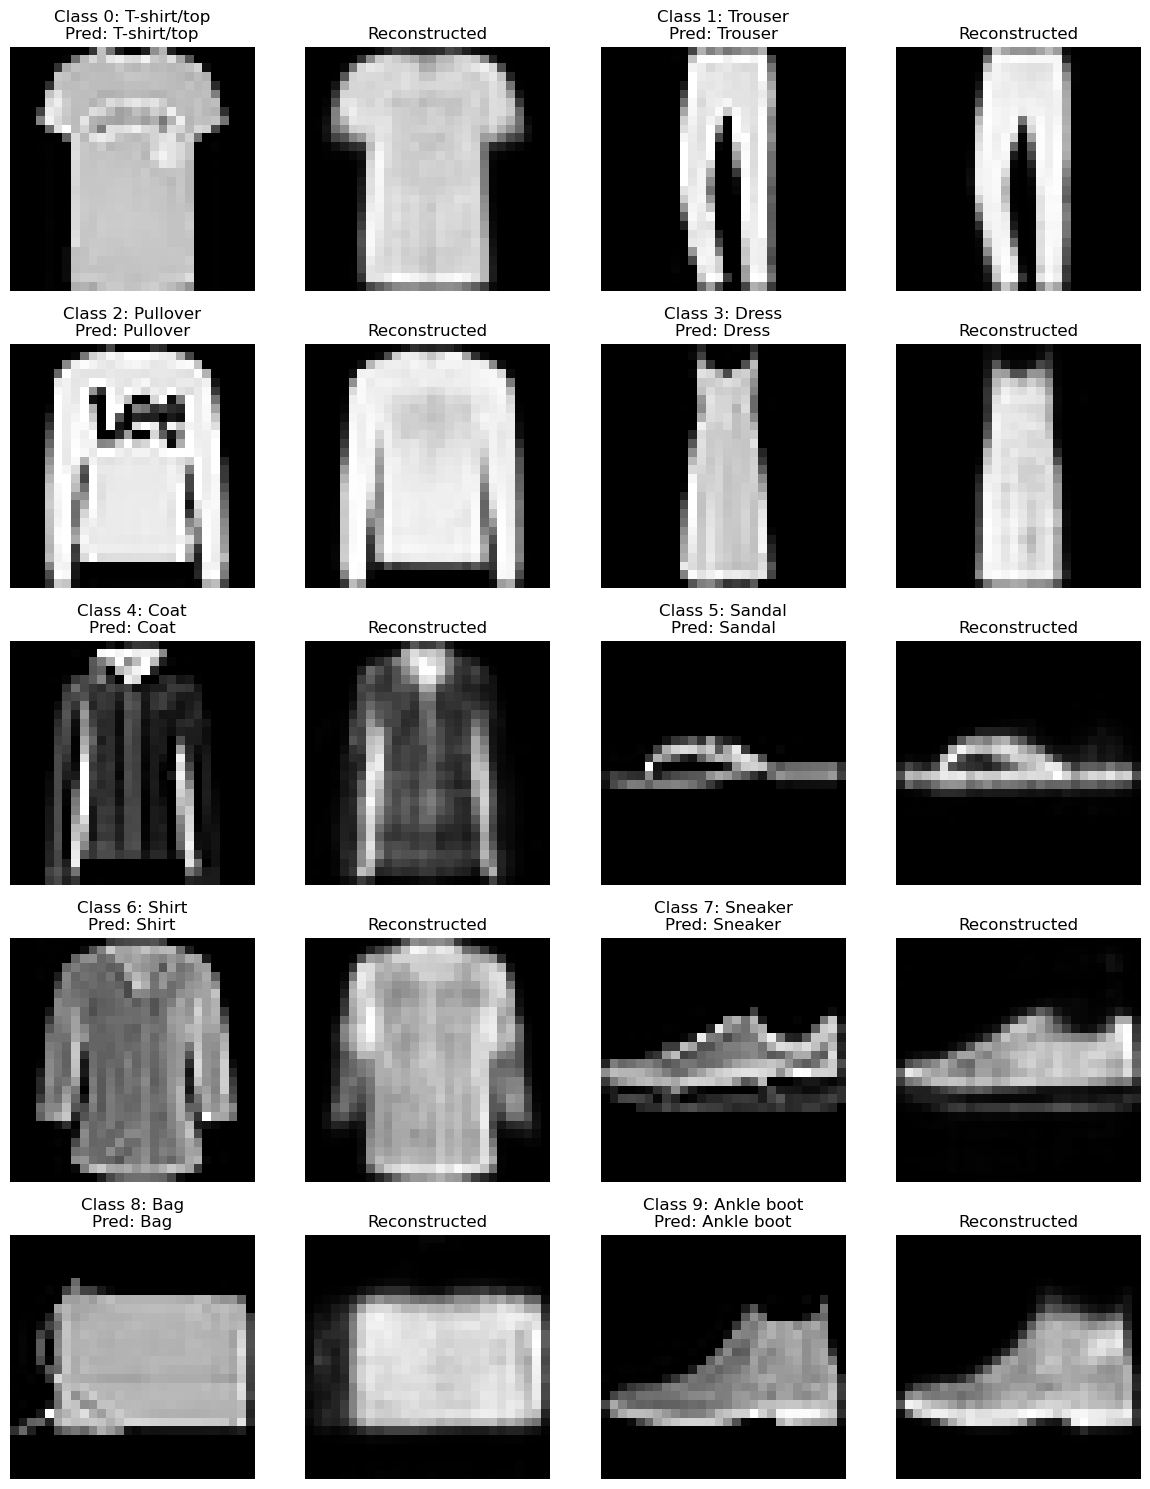


Model Performance on Test Examples:
Example 1: Class 0 (T-shirt/top)
  Predicted: Class 0 (T-shirt/top)
  Result: ✓ Correct

Example 2: Class 1 (Trouser)
  Predicted: Class 1 (Trouser)
  Result: ✓ Correct

Example 3: Class 2 (Pullover)
  Predicted: Class 2 (Pullover)
  Result: ✓ Correct

Example 4: Class 3 (Dress)
  Predicted: Class 3 (Dress)
  Result: ✓ Correct

Example 5: Class 4 (Coat)
  Predicted: Class 4 (Coat)
  Result: ✓ Correct

Example 6: Class 5 (Sandal)
  Predicted: Class 5 (Sandal)
  Result: ✓ Correct

Example 7: Class 6 (Shirt)
  Predicted: Class 6 (Shirt)
  Result: ✓ Correct

Example 8: Class 7 (Sneaker)
  Predicted: Class 7 (Sneaker)
  Result: ✓ Correct

Example 9: Class 8 (Bag)
  Predicted: Class 8 (Bag)
  Result: ✓ Correct

Example 10: Class 9 (Ankle boot)
  Predicted: Class 9 (Ankle boot)
  Result: ✓ Correct

Accuracy on these examples: 10/10 (100.0%)


In [18]:
# Define the class names for the 10 categories in Fashion MNIST
classes: List[str] = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Set the model to evaluation mode
model.eval()

# Function to find examples of each class in the test dataset
def find_examples_of_all_classes(dataset, classes_list):
    # Create a dictionary to store indices for each class
    class_indices = {i: [] for i in range(len(classes_list))}
    
    # Find examples of each class
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        # Store up to 2 examples of each class
        if len(class_indices[label]) < 2:
            class_indices[label].append(idx)
        
        # Check if we have enough examples of each class
        if all(len(indices) >= 2 for indices in class_indices.values()):
            break
    
    # Return first example of each class
    return [indices[0] for indices in class_indices.values()]

# Get example indices for all 10 classes
example_indices = find_examples_of_all_classes(test_data, classes)

# Create a figure with 5 rows and 4 columns (10 examples, each with original and reconstruction)
plt.figure(figsize=(12, 15))

# Make predictions and display each class
with torch.no_grad():  # Disable gradient calculation for inference
    for i, idx in enumerate(example_indices):
        # Get the test example
        x, y = test_data[idx][0], test_data[idx][1]
        
        # Move image to device and make prediction
        x = x.to(device)
        class_pred, reconstructed = model(x.unsqueeze(0))
        
        # Get predicted class and actual class
        predicted = classes[class_pred[0].argmax(0)]
        actual = classes[y]
        
        # Original image - left column
        plt.subplot(5, 4, i*2+1)
        plt.title(f"Class {i}: {actual}\nPred: {predicted}")
        plt.imshow(x.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        
        # Reconstructed image - right column
        plt.subplot(5, 4, i*2+2)
        plt.title("Reconstructed")
        plt.imshow(reconstructed[0].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Print overall statistics
print("\nModel Performance on Test Examples:")
num_correct = 0

with torch.no_grad():
    for i, idx in enumerate(example_indices):
        x, y = test_data[idx][0], test_data[idx][1]
        x = x.to(device)
        class_pred, _ = model(x.unsqueeze(0))
        predicted_class = class_pred[0].argmax(0).item()
        actual_class = y
        
        is_correct = predicted_class == actual_class
        if is_correct:
            num_correct += 1
            
        print(f"Example {i+1}: Class {actual_class} ({classes[actual_class]})")
        print(f"  Predicted: Class {predicted_class} ({classes[predicted_class]})")
        print(f"  Result: {'✓ Correct' if is_correct else '✗ Incorrect'}\n")

print(f"Accuracy on these examples: {num_correct}/{len(example_indices)} ({num_correct/len(example_indices)*100:.1f}%)")

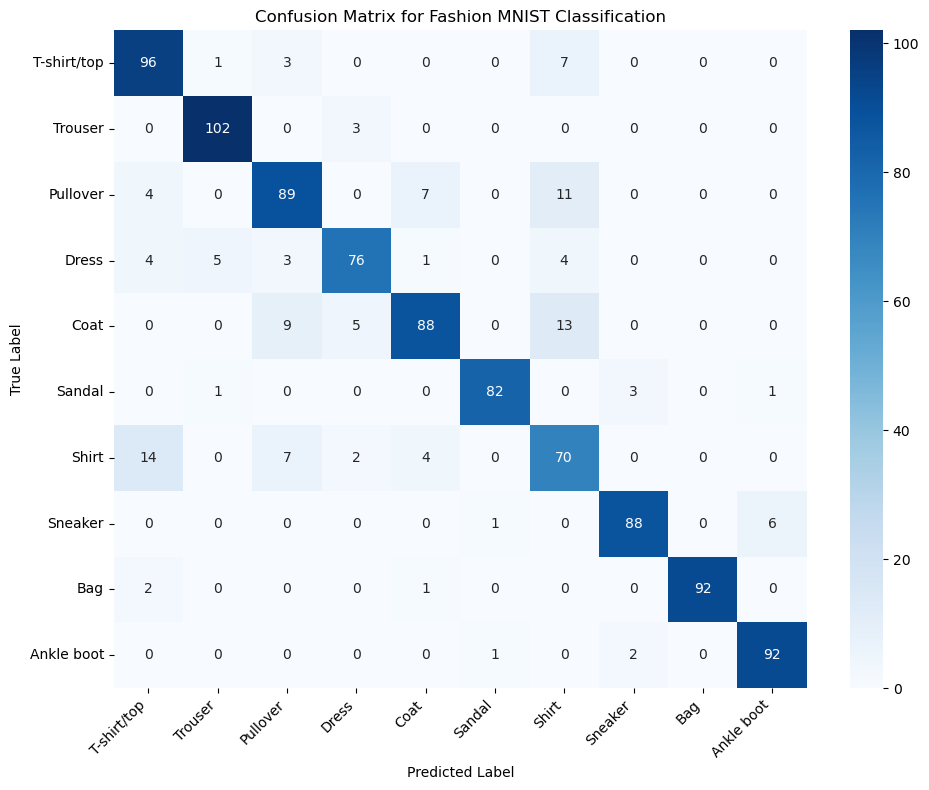

Class 0 (T-shirt/top):
  Precision: 0.80
  Recall: 0.90
  F1-score: 0.85
Class 1 (Trouser):
  Precision: 0.94
  Recall: 0.97
  F1-score: 0.95
Class 2 (Pullover):
  Precision: 0.80
  Recall: 0.80
  F1-score: 0.80
Class 3 (Dress):
  Precision: 0.88
  Recall: 0.82
  F1-score: 0.85
Class 4 (Coat):
  Precision: 0.87
  Recall: 0.77
  F1-score: 0.81
Class 5 (Sandal):
  Precision: 0.98
  Recall: 0.94
  F1-score: 0.96
Class 6 (Shirt):
  Precision: 0.67
  Recall: 0.72
  F1-score: 0.69
Class 7 (Sneaker):
  Precision: 0.95
  Recall: 0.93
  F1-score: 0.94
Class 8 (Bag):
  Precision: 1.00
  Recall: 0.97
  F1-score: 0.98
Class 9 (Ankle boot):
  Precision: 0.93
  Recall: 0.97
  F1-score: 0.95

Overall Metrics:
  Precision: 0.88
  Recall: 0.88
  F1-score: 0.88


In [ ]:
# Let's create a confusion matrix to better understand model performance across classes
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Number of test samples to use for confusion matrix
num_samples = 1000  # We'll use 1000 test samples (around 100 per class)

# Collect predictions and true labels
y_true = []
y_pred = []

with torch.no_grad():
    for i in range(min(num_samples, len(test_data))):
        x, y = test_data[i][0], test_data[i][1]
        x = x.to(device)
        class_pred, _ = model(x.unsqueeze(0))
        predicted_idx = class_pred[0].argmax(0).item()
        
        y_true.append(y)
        y_pred.append(predicted_idx)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fashion MNIST Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate metrics by class
precision_by_class = []
recall_by_class = []
f1_by_class = []

for i in range(10):
    # True positives: correctly predicted as class i
    tp = cm[i, i]
    
    # False positives: incorrectly predicted as class i
    fp = cm[:, i].sum() - tp
    
    # False negatives: class i incorrectly predicted as something else
    fn = cm[i, :].sum() - tp
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_by_class.append(precision)
    recall_by_class.append(recall)
    f1_by_class.append(f1)
    
    print(f"Class {i} ({classes[i]}):\n  Precision: {precision:.2f}\n  Recall: {recall:.2f}\n  F1-score: {f1:.2f}")

# Calculate overall metrics
overall_precision = np.mean(precision_by_class)
overall_recall = np.mean(recall_by_class)
overall_f1 = np.mean(f1_by_class)

print(f"\nOverall Metrics:\n  Precision: {overall_precision:.2f}\n  Recall: {overall_recall:.2f}\n  F1-score: {overall_f1:.2f}")